# Examine Model Predictions

* The model tends to predict fewer BP nerve collections (22%) than the ground truth suggests (41%).
* Among the positive predictions, the model tends to identify smaller areas of nerves even if some pixel predictions are correct. 
* There are cases of false positives where the model falsely identifies as nerves when there is none in reality.
* Among the images that are labelled by experts to have nerves, the model fails to identify the presence of or the entire nerve collection. 
* The model does poorly when it predicts the maximum pixel value in an image is bewteen 0.2 and 0.8.
* The model does well in predicting some training exampls with large mask areas. But it appears that there are some inconsistent labeling for the same subject. For instance, subject 16 has images that are very similar but some were identified to have BP nerves while others weren't.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
from data import load_train_data, load_test_data, image_cols, image_rows
from skimage.transform import resize

% matplotlib inline

In [3]:
import train
from train import get_unet, preprocess

# Load the weights of the neural network model previously trained
model = get_unet()
model.load_weights('weights.h5')

Using TensorFlow backend.


In [38]:
# Load and process the training images and make model predictions
imgs_train, imgs_mask_train, subjects = load_train_data()
train = preprocess(imgs_train)
train = train.astype('float32')
mean = np.mean(train)  # mean for data centering
std = np.std(train)  # std for data normalization
train = (train - mean) / std
predict_train = model.predict(train, verbose=1)

5635/5635 [==============================] - 108s   


In [39]:
predict_train.shape

(5635, 96, 96, 1)

In [119]:
# Resize the images back to the original size of 420x580
n_train = predict_train.shape[0]
max_train = []
sum_train = []
pred_train = np.ndarray(shape=(n_train, image_rows, image_cols, 1))

for i in range(n_train):
    img = predict_train[i]
    pred_train[i] = resize(img, (image_rows, image_cols), preserve_range=True, mode='constant')
    max_train.append(img.max())
    sum_train.append(img.sum())
    if i % 1000 == 0:
        print('{}/{}'.format(i, n_train))

0/5635
1000/5635
2000/5635
3000/5635
4000/5635
5000/5635


In [102]:
import pandas as pd
max_train = pd.Series(max_train)
positive = (max_train>0.5).sum()/len(max_train)
print("The model predicts that {:.1f}% of training images have BP nerves.".format(positive*100))

The model predicts that 21.5% of training images have BP nerves.


In [103]:
true_max = []
for i in range(n_train):
    true_max.append(imgs_mask_train[i].max()/255)
    
true_max = pd.Series(true_max)
true_positive = (true_max>0.5).sum()/len(true_max)
print("The truth is that {:.1f}% of training images have BP nerves.".format(true_positive*100))

The truth is that 41.2% of training images have BP nerves.


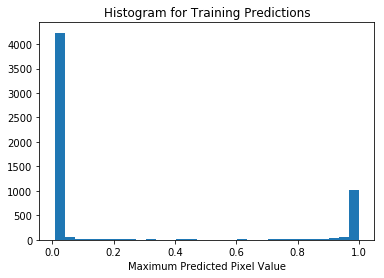

In [120]:
plt.hist(max_train, bins=30)
plt.xlabel('Maximum Predicted Pixel Value')
plt.title('Histogram for Training Predictions')
plt.show()

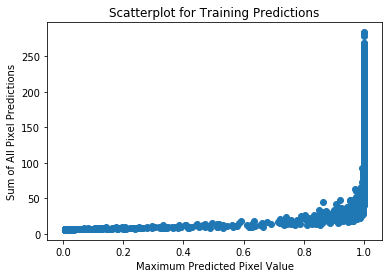

In [124]:
plt.scatter(max_train, sum_train)
plt.xlabel("Maximum Predicted Pixel Value")
plt.ylabel("Sum of All Pixel Predictions")
plt.title("Scatterplot for Training Predictions")
plt.show()

There must be quite a few false negatives that the model fails to identify as nerves. 

In [92]:
ind_true = true_max.loc[true_max>0.5].index.values
ind_pred = max_train.loc[max_train>0.5].index.values

In [94]:
def plot_masks(i):
    """ Plot the original training image and compare the ground truth with predictions"""
    plt.figure(figsize=(14,6))
    ax = plt.subplot(131)
    ax.set_title("Original Image")
    plt.imshow(imgs_train[i], cmap=cm.gray)
    ax = plt.subplot(132)
    ax.set_title("Ground Truth Mask")
    plt.imshow(imgs_train[i], cmap=cm.gray)
    my_cmap = cm.OrRd
    my_cmap.set_under(alpha=0)
    plt.imshow(imgs_mask_train[i], cmap=my_cmap, clim=[0.9, 1])
    ax = plt.subplot(133)
    ax.set_title("Predicted Mask")
    plt.imshow(imgs_train[i], cmap=cm.gray)
    my_cmap = cm.BuPu
    my_cmap.set_under(alpha=0)
    plt.imshow(np.squeeze(pred_train[i]), cmap=my_cmap, clim=[0.9, 1])
    plt.show()
    print("Maximum pixel value in predicted mask: {:.4f}".format(max_train[i]))
    print("Subject number: {}".format(subjects[i]))

### Positive Predictions
Among the positive predictions, the model tends to identify smaller areas of nerves even if some pixel predictions are correct. There are also cases of false positives where the model falsely identifies as nerves when there is none in reality. 

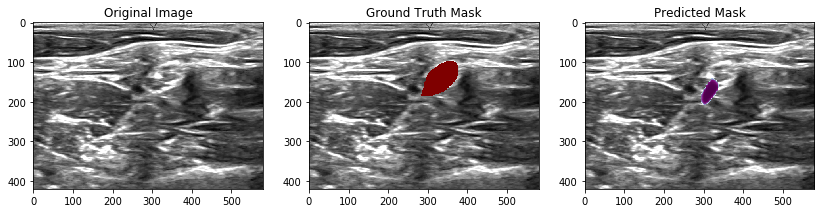

Maximum pixel value in predicted mask: 0.9997
Subject number: 11


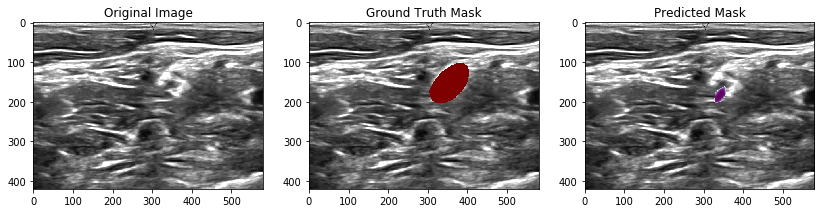

Maximum pixel value in predicted mask: 0.9969
Subject number: 11


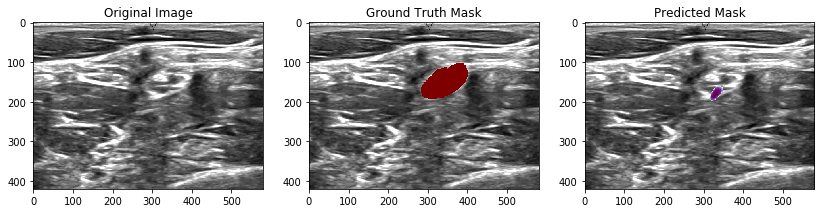

Maximum pixel value in predicted mask: 0.9975
Subject number: 11


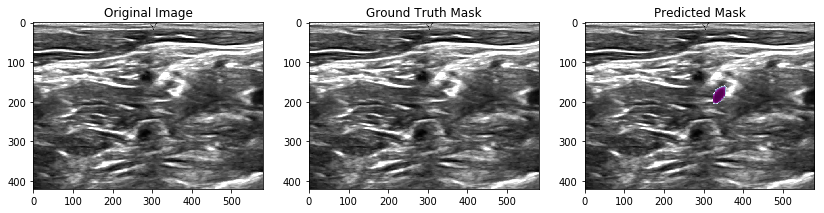

Maximum pixel value in predicted mask: 0.9989
Subject number: 11


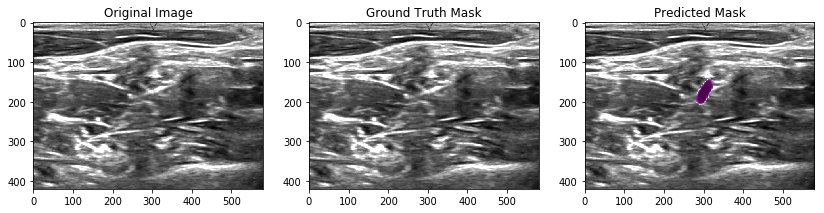

Maximum pixel value in predicted mask: 0.9997
Subject number: 11


In [108]:
for i in range(5,10):
    plot_masks(ind_pred[i])

### Groun Truth
Among the images that are labelled by experts to have nerves, the model fails to identify the presence of or the entire nerve collection. 

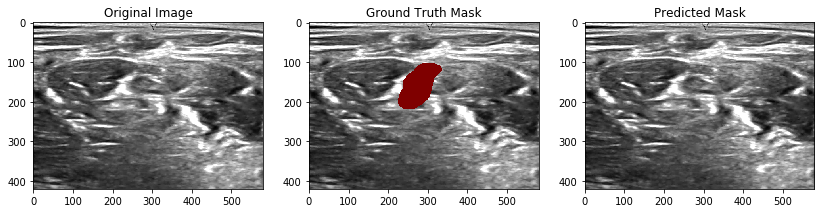

Maximum pixel value in predicted mask: 0.0118
Subject number: 10


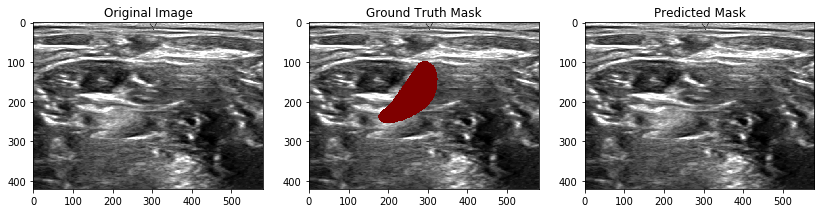

Maximum pixel value in predicted mask: 0.0103
Subject number: 10


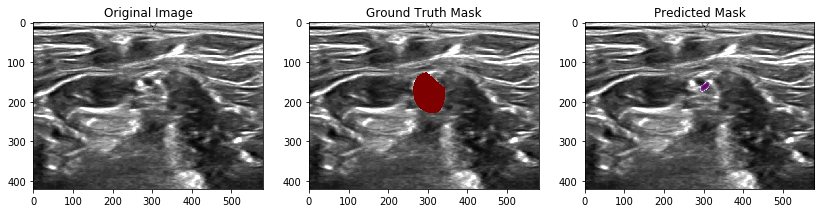

Maximum pixel value in predicted mask: 0.9951
Subject number: 10


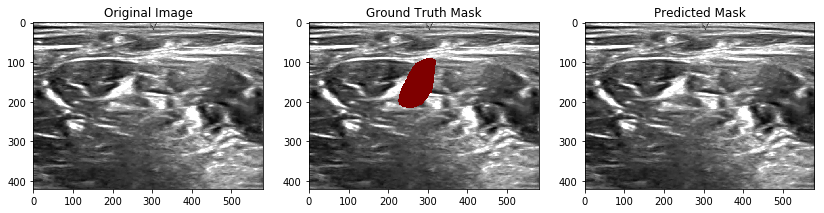

Maximum pixel value in predicted mask: 0.0101
Subject number: 10


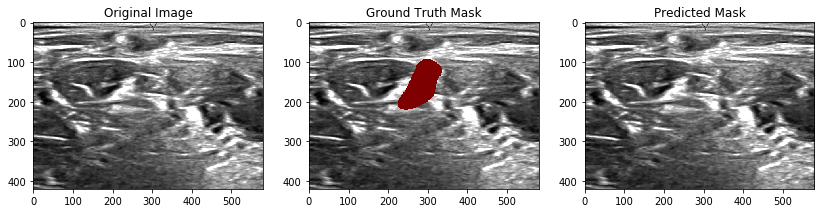

Maximum pixel value in predicted mask: 0.0110
Subject number: 10


In [109]:
for i in range(5):
    plot_masks(ind_true[i])

### Poor Predictions

The model does poorly when it predicts the maximum pixel value in an image is bewteen 0.2 and 0.8. 

In [105]:
# Check the maximum prediction values that are within 0.2 to 0.8
ind_0208 = max_train.loc[(max_train>0.2) & (max_train<0.8)].index.values
ind_0208.shape

(122,)

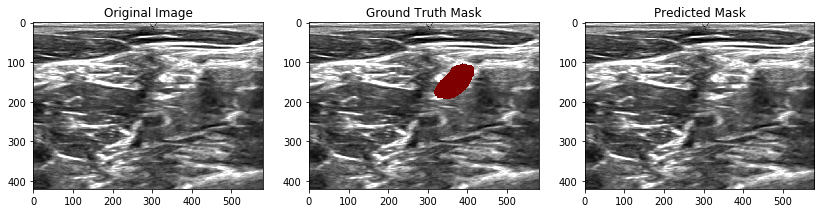

Maximum pixel value in predicted mask: 0.6768
Subject number: 11


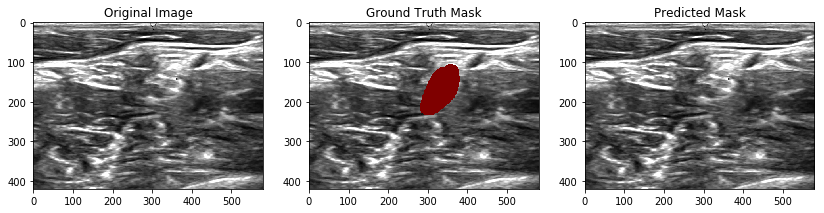

Maximum pixel value in predicted mask: 0.7578
Subject number: 11


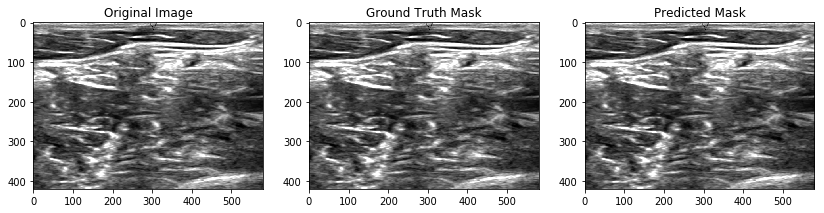

Maximum pixel value in predicted mask: 0.7239
Subject number: 11


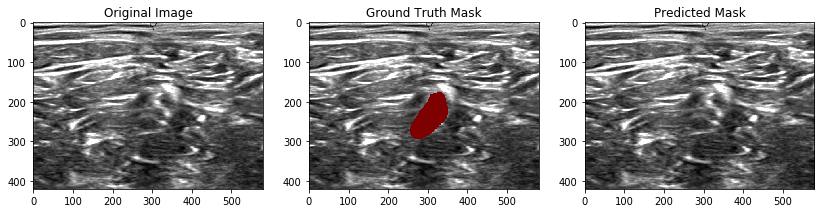

Maximum pixel value in predicted mask: 0.2030
Subject number: 13


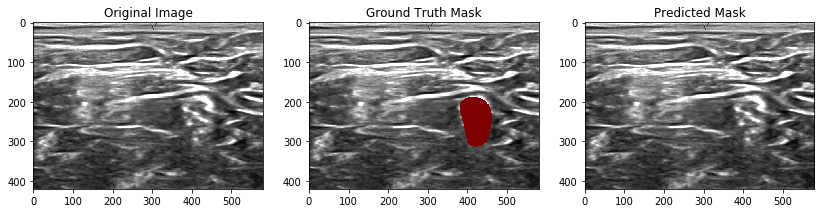

Maximum pixel value in predicted mask: 0.7654
Subject number: 13


In [107]:
for i in range(10,15):
    plot_masks(ind_0208[i])

### Positive Predictions with Large Mask Areas
The model does well in predicting some training exampls with large mask areas. But it appears that there are some inconsistent labeling for the same subject. For instance, subject 16 has images that are very similar but some were identified to have BP nerves while others weren't.

In [129]:
sum_train = pd.Series(sum_train)

In [132]:
ind_size = np.argsort(-sum_train)

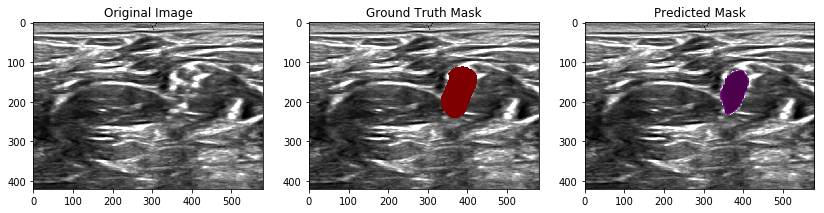

Maximum pixel value in predicted mask: 1.0000
Subject number: 16


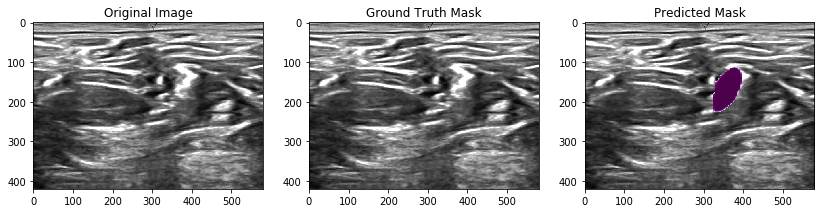

Maximum pixel value in predicted mask: 1.0000
Subject number: 16


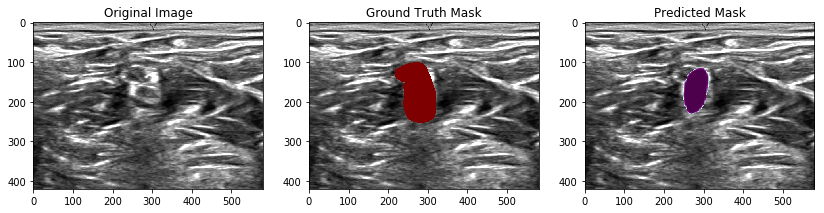

Maximum pixel value in predicted mask: 1.0000
Subject number: 16


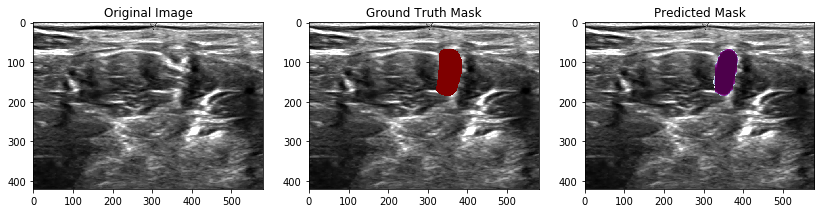

Maximum pixel value in predicted mask: 1.0000
Subject number: 23


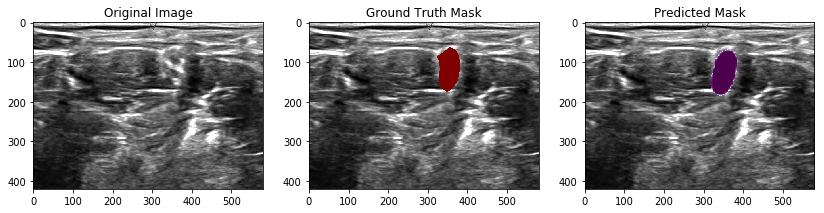

Maximum pixel value in predicted mask: 1.0000
Subject number: 23


In [136]:
for i in range(3,8):
    plot_masks(ind_size[i])

In [110]:
# Examine Test Predcitions

orig_test, imgs_id_test = load_test_data()
imgs_test = np.load('imgs_mask_test.npy')

argsort = np.argsort(imgs_id_test)
imgs_id_test = imgs_id_test[argsort]
imgs_test = imgs_test[argsort]

In [111]:
orig_test.shape

(5508, 420, 580)

In [112]:
imgs_test.shape

(5508, 96, 96, 1)

In [113]:
total = imgs_test.shape[0]

test_maxs = []
test_sums = []
pred = np.ndarray(shape=(total, image_rows, image_cols, 1))

for i in range(total):
    img = imgs_test[i]
    pred[i] = resize(img, (image_rows, image_cols), preserve_range=True, mode='constant')
    test_maxs.append(img.max())
    test_sums.append(img.sum())
    if i % 1000 == 0:
        print('{}/{}'.format(i, total))

0/5508
1000/5508
2000/5508
3000/5508
4000/5508
5000/5508


In [118]:
test_maxs = pd.Series(test_maxs)
test_pos = (test_maxs>0.5).sum()/len(test_maxs)
print("The model predicts that {:.1f}% of training images have BP nerves.".format(test_pos*100))

The model predicts that 23.0% of training images have BP nerves.


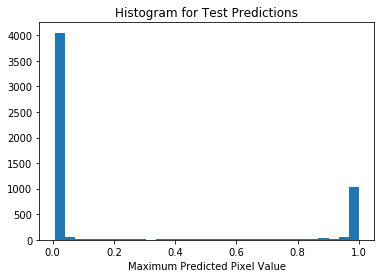

In [121]:
plt.hist(test_maxs, bins=30)
plt.xlabel('Maximum Predicted Pixel Value')
plt.title('Histogram for Test Predictions')
plt.show()

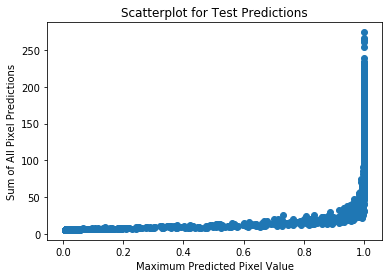

In [122]:
plt.scatter(test_maxs, test_sums)
plt.xlabel("Maximum Predicted Pixel Value")
plt.ylabel("Sum of All Pixel Predictions")
plt.title("Scatterplot for Test Predictions")
plt.show()